# **Deep Learning**
 

# **Variational AutoEncoder**

## **Lab Assignment 6**

**Harsh Tomar B21AI049**

---

## **Importing Necessary Libraries**

In [39]:
# Importing Necessary Libraries


import torch 
import torch.nn as nn 

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from torch import optim
from torch.optim import lr_scheduler


import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Import Image
from PIL import Image
import os


---

## **Device**

In [40]:
# Setting the device to GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


---

## **Importing Dataset**

**Preparing Custom Dataset and DataLoaders**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


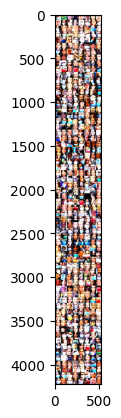

In [324]:
# Importing the Face Mask Detection Dataset
# We have it locally in the ./Face Mask Dataset/Test and ./Face Mask Dataset/Train

# Creating a Custom Dataset Class  

class FaceMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        
        self.classes = ['WithMask', 'WithoutMask']
        
        self.data = []
        
        for label in self.classes:
            files = os.listdir(os.path.join(root, label))
            self.data += list(zip(files, [label]*len(files)))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_file, label = self.data[index]
        
        img = Image.open(os.path.join(self.root, label, img_file))
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, self.classes.index(label)

# Defining the Transformations

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating the Train and Test Datasets

train_dataset = FaceMaskDataset('./Face Mask Dataset/Train', transform=transform)
test_dataset = FaceMaskDataset('./Face Mask Dataset/Test', transform=transform)
val_dataset = FaceMaskDataset('./Face Mask Dataset/Validation', transform=transform)

# Creating the Data Loaders

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)

# Visualizing the Data

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


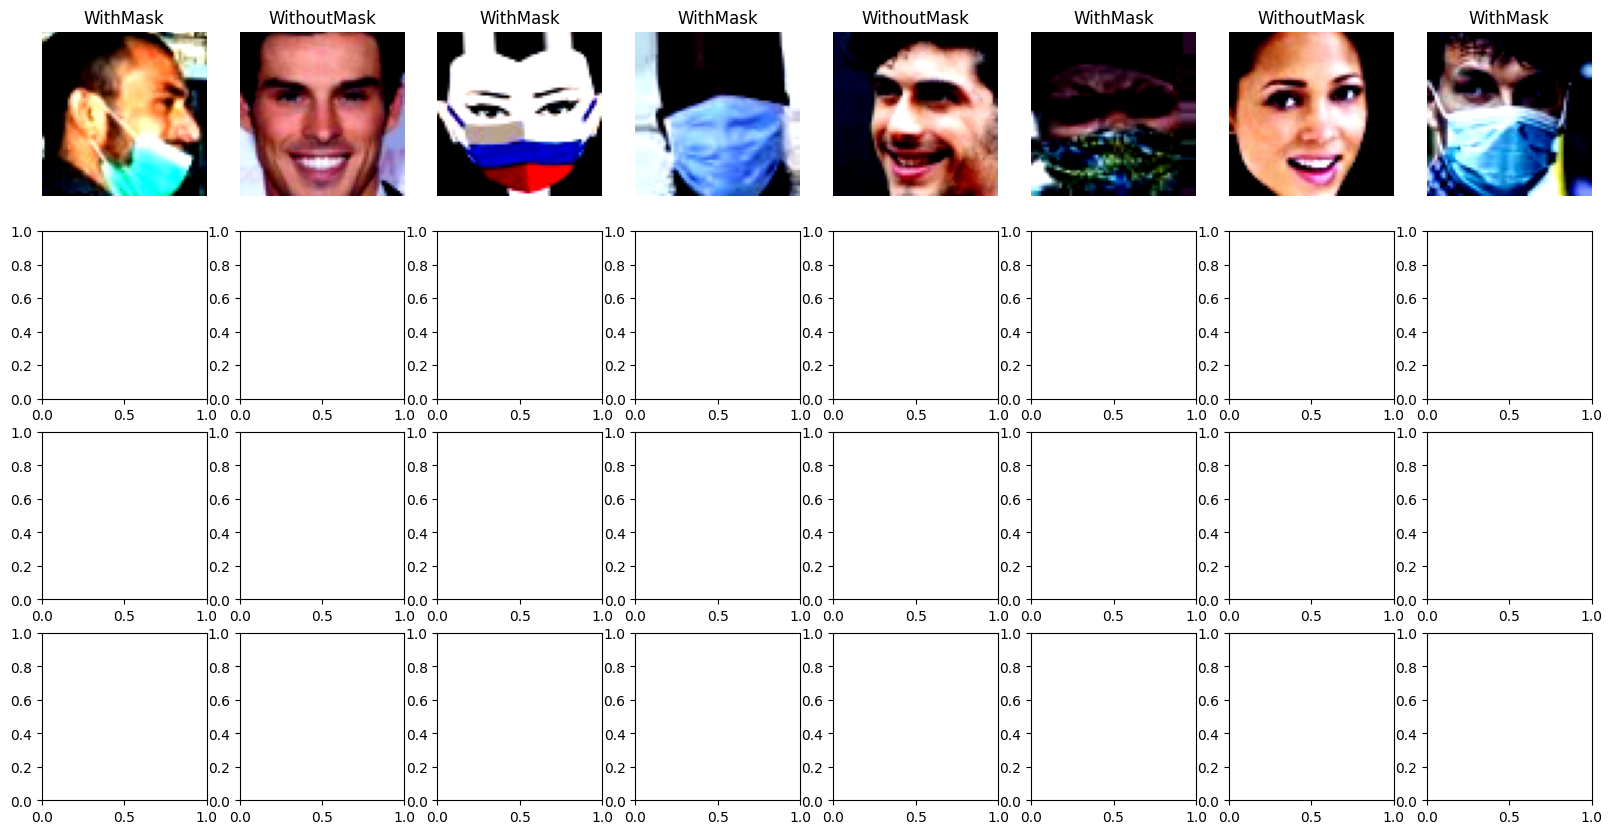

In [42]:
# Showing Grid of Images along side their labels in plotly

def show_grid_images(images, labels, classes):
    fig, ax = plt.subplots(4, 8, figsize=(20, 10))
    for i in range(8):
        ax[i//8, i%8].imshow(images[i].permute(1, 2, 0) / 2 + 0.25)
        ax[i//8, i%8].set_title(classes[labels[i]])
        ax[i//8, i%8].axis('off')
    plt.show()

show_grid_images(images, labels, train_dataset.classes)


---

## **VAE Architecture**

### **1. Integration of U-Net Connections into the VAE Architectures**

In [43]:
print('hello')

hello


In [325]:
# Architecture of VAE with UNET Skip Connections from the Encoder to the Decoder

# Encoder Architecture that takes in an Image and outputs the Mean and Variance of the Latent Space (it has to first downsample the image like a unet architecture)

# VAE + UNET Encoder for 64 X 64 Images

class VAE_UNET_Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super(VAE_UNET_Encoder, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3,  padding=1)
        #self.conv11 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        #self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        #self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Latent Space
        self.fc_mu = nn.Linear(64*8*8, latent_dim)
        self.fc_var = nn.Linear(64*8*8, latent_dim)
        # Why do we have 256*8*8 as the input to the fully connected layer?
        # The input to the fully connected layer is the flattened output of the last max pool layer
        # The last max pool layer reduces the image size to 8 X 8
        # The number of channels in the last max pool layer is 256
        # Each max pool layer reduces the image size by half
        # We have used 3 max pool layers
        # 
        # 64 X 64 -> 32 X 32 -> 16 X 16 -> 8 X 8

    
    
        
    def forward(self, x):
        x1 = ((self.conv1(x)))
        x = self.mp1(x1)
        x2 = ((self.conv2(x)))
        x = self.mp2(x2)
        x3 = ((self.conv3(x)))
        x = self.mp3(x3)



        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)

        log_var = self.fc_var(x)

        return mu, log_var, x1, x2, x3

# Decoder Architecture that takes in the Mean and Variance of the Latent Space and outputs the Reconstructed Image

# VAE + UNET Decoder for 64 X 64 Images

class VAE_UNET_Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super(VAE_UNET_Decoder, self).__init__()
        
        self.fc = nn.Linear(latent_dim, 64*8*8)
        
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        #self.conv11 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        #self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        #self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv4 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x, x1, x2, x3):
        x = self.fc(x)
        x = x.view(x.size(0), 64, 8, 8)
        x = self.up1(x)
        x_ = torch.cat([x, x3], dim=1)

        #print(x_.size())
        x = ((self.conv1(x_)))
        x = self.up2(x)
        x_ = torch.cat([x, x2], dim=1)
        x = ((self.conv2(x_)))
        x = self.up3(x)
        x_ = torch.cat([x, x1], dim=1)
        x = ((self.conv3(x_)))
        x = torch.sigmoid(self.conv4(x))
        return x


# VAE Architecture that combines the Encoder and Decoder

class VAE_UNET(nn.Module):
    def __init__(self, in_channels, out_channels, latent_dim):
        super(VAE_UNET, self).__init__()
        
        self.encoder = VAE_UNET_Encoder(in_channels, latent_dim)
        self.decoder = VAE_UNET_Decoder(latent_dim, out_channels)
        
    def forward(self, x):
        mu, log_var, x1, x2, x3 = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z, x1, x2, x3)
        return x_recon, mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps*std

# Creating the VAE Model

# Model with 3 Latent Variables (Latent Space Dimension = 3)
# Input Image Size = 64 X 64
# Output Image Size = 64 X 64
# Number of Channels in the Input Image = 3
# Number of Channels in the Output Image = 3


model = VAE_UNET(3, 3, 5).to(device)

# Defining the Loss Function and Optimizer

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the VAE Model

num_epochs = 10

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        img_recon, mu, log_var = model(img)
        loss = criterion(img_recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the VAE Model

model.eval()

with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)
        img_recon, mu, log_var = model(img)
        loss = criterion(img_recon, img)
        
    print(f'Loss: {loss.item():.4f}')
    
    img_recon = img_recon.cpu()
    img_recon = torchvision.utils.make_grid(img_recon)
    img_recon = img_recon.permute(1, 2, 0)
    
    img = img.cpu()
    img = torchvision.utils.make_grid(img)
    img = img.permute(1, 2, 0)
    
    plt.imshow(img_recon)
    plt.axis('off')
    plt.show()
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()




Epoch [0/10], Loss: 0.8309


KeyboardInterrupt: 

In [322]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = VAE_UNET(3, 3, 5).to(device)  # Replace with your model instantiation
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")


Number of trainable parameters: 213181


---